In [155]:
%load_ext autoreload 
%autoreload 2
import cv2
import json, os, cv2
from pathlib import Path
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import xarray as xr
import seaborn as sns
import h5py as hf
from tqdm import tqdm
from tqdm import tqdm
import itertools 
from scipy.interpolate import interp1d
from scipy import signal
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors
import os, fnmatch

import sys
sys.path.insert(0, 'C:/Users/nlab/Documents/GitHub/obstacle_avoidance')

from utils.base_functions import format_frames,flatten_column,list_columns
from src.utils.auxiliary import flatten_series
from src.utils.path import find
from src.base import BaseInput

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [437]:
## take raw_df from multiple session and plt  
class plot_oa(BaseInput):

    def __init__(self,metadata_path,cluster=False,plot_trace=False):
        with open(metadata_path) as f:
            self.metadata = json.load(f)

        self.path = self.metadata['path']
        self.dates_list = [i for i in list(self.metadata.keys()) if i != 'path' ]
        
    def gather_session_df(self):
        # list data path files
        data_path = Path(self.path).expanduser()
        # find date
        hf_list = []
        df =pd.DataFrame()
        for date in self.dates_list:
            use_animals = [k for k,v in self.metadata[date].items()]
            for ani in use_animals:
                for task in os.listdir(data_path / date / ani):
                    h5_paths=[str(i) for i in list((data_path / date / ani/ task).rglob('*.h5'))]
                    raw_h5 = [i for i in h5_paths if 'raw' in i]
                    hf_list.append(raw_h5)
        hf_list = list(itertools.chain(*hf_list))
        for h5 in hf_list:
            data = pd.read_hdf(h5)
            df=df.append(data,ignore_index=True)
        self.df=df
        for ind, row in self.df.iterrows():
            self.df.at[ind,'exp'] = row['animal'] + '_' + row['date']
            #self.df = self.df.reset_index()
    def check_tracking(self,vid_path,num_trials,animal):
        frames = format_frames(vid_path)
        ## create animal df\
    def cluster(self):
        self.df = self.df[self.df['gt_obstacle_cen_x_cm'].notna()]


        kmeans_input = np.vstack([self.df['gt_obstacle_cen_x_cm'].values, self.df['gt_obstacle_cen_y_cm'].values])

        kmeans_input = np.transpose(kmeans_input)

        labels = KMeans(n_clusters=9).fit(kmeans_input).labels_
        self.df['obstacle_cluster'] = labels
    def plot_trace_cluster(self,savepath,filename):
        pdf = PdfPages(os.path.join(savepath,(filename) + '_figs.pdf'))
        plt.figure()
        plt.subplots(3,3, figsize=(25,21))

        for clusters, cluster_name in enumerate(self.df['obstacle_cluster'].unique()):
            x=self.df.loc[self.df['obstacle_cluster']==cluster_name]
            for i, row in x.iterrows():
                if row['odd'] == False:
                    plt.subplot(3,3,cluster_name+1)
                    plt.gca().set_aspect('equal', adjustable='box')
                    plt.gca().set_title(str(row['odd'])+str(row['obstacle_cluster']))

                    plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                        [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='red')


                    plt.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
                        [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')




                    plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='blue')
                    plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
                    plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')
                    sns.scatterplot(x=row['ts_nose_x_cm'],y=row['ts_nose_y_cm'],hue = enumerate(row['ts_nose_x_cm']), palette ='magma',legend=False) 
                    #plt.scatter(row['wobstacle_x_cm'], row['wobstacle_y_cm'], c = list(mcolors.TABLEAU_COLORS)[ row['obstacle_cluster']])
                    plt.ylim([0,52]); plt.xlim([0, 72])
        pdf.savefig(); plt.close()

        for clusters, cluster_name in enumerate(self.df['obstacle_cluster'].unique()):
            x=self.df.loc[self.df['obstacle_cluster']==cluster_name]
            for i, row in x.iterrows():
                if row['odd'] == True:
                    plt.subplot(3,3,cluster_name+1)
                    plt.gca().set_aspect('equal', adjustable='box')
                    plt.gca().set_title(str(row['odd'])+str(row['obstacle_cluster']))

                    plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                        [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='red')


                    plt.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
                        [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')




                    plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='blue')
                    plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
                    plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')
                    sns.scatterplot(x=row['ts_nose_x_cm'],y=row['ts_nose_y_cm'],hue = enumerate(row['ts_nose_x_cm']), palette ='magma',legend=False) 
                    #plt.scatter(row['wobstacle_x_cm'], row['wobstacle_y_cm'], c = list(mcolors.TABLEAU_COLORS)[ row['obstacle_cluster']])
                    plt.ylim([0,52]); plt.xlim([0, 72])
        pdf.savefig(); plt.close()
        pdf.close()







    
    #def cluster(self
        

                        



        


        

In [429]:
session = plot_oa('D:/obstacle_avoidance/metadata/J20RT.json')

In [430]:
session.gather_session_df()
df = session.df

In [438]:
session.cluster('D:\obstacle_avoidance\figures\tracking_oa','J20RT' )

TypeError: cluster() takes 1 positional argument but 3 were given

In [439]:
session.plot_trace_cluster('D:obstacle_avoidance/figures/tracking_oa','J20RT' )

In [149]:
df['exp'].unique()

array(['J19LT_101322', 'J19RT_101322', 'J20LT_101322', 'J20RT_101322'],
      dtype=object)

In [156]:
df = pd.read_hdf(r"D:\obstacle_avoidance\recordings\101422\J20LT\oa\raw_J20LT_101422_oa.h5")
frames = format_frames(r"D:\obstacle_avoidance\recordings\101422\J20LT\oa\101422_J20LT_control_Rig2_oa_top1.avi",.25)

100%|██████████| 29212/29212 [00:29<00:00, 980.64it/s] 


In [161]:
frames.shape

(29212, 135, 180)

In [ ]:
df = pd.read_hdf(r"D:\obstacle_avoidance\recordings\101422\J20LT\oa\raw_J20LT_101422_oa.h5")
frames = format_frames(r"D:\obstacle_avoidance\recordings\101422\J20LT\oa\101422_J20LT_control_Rig2_oa_top1.avi",.25)

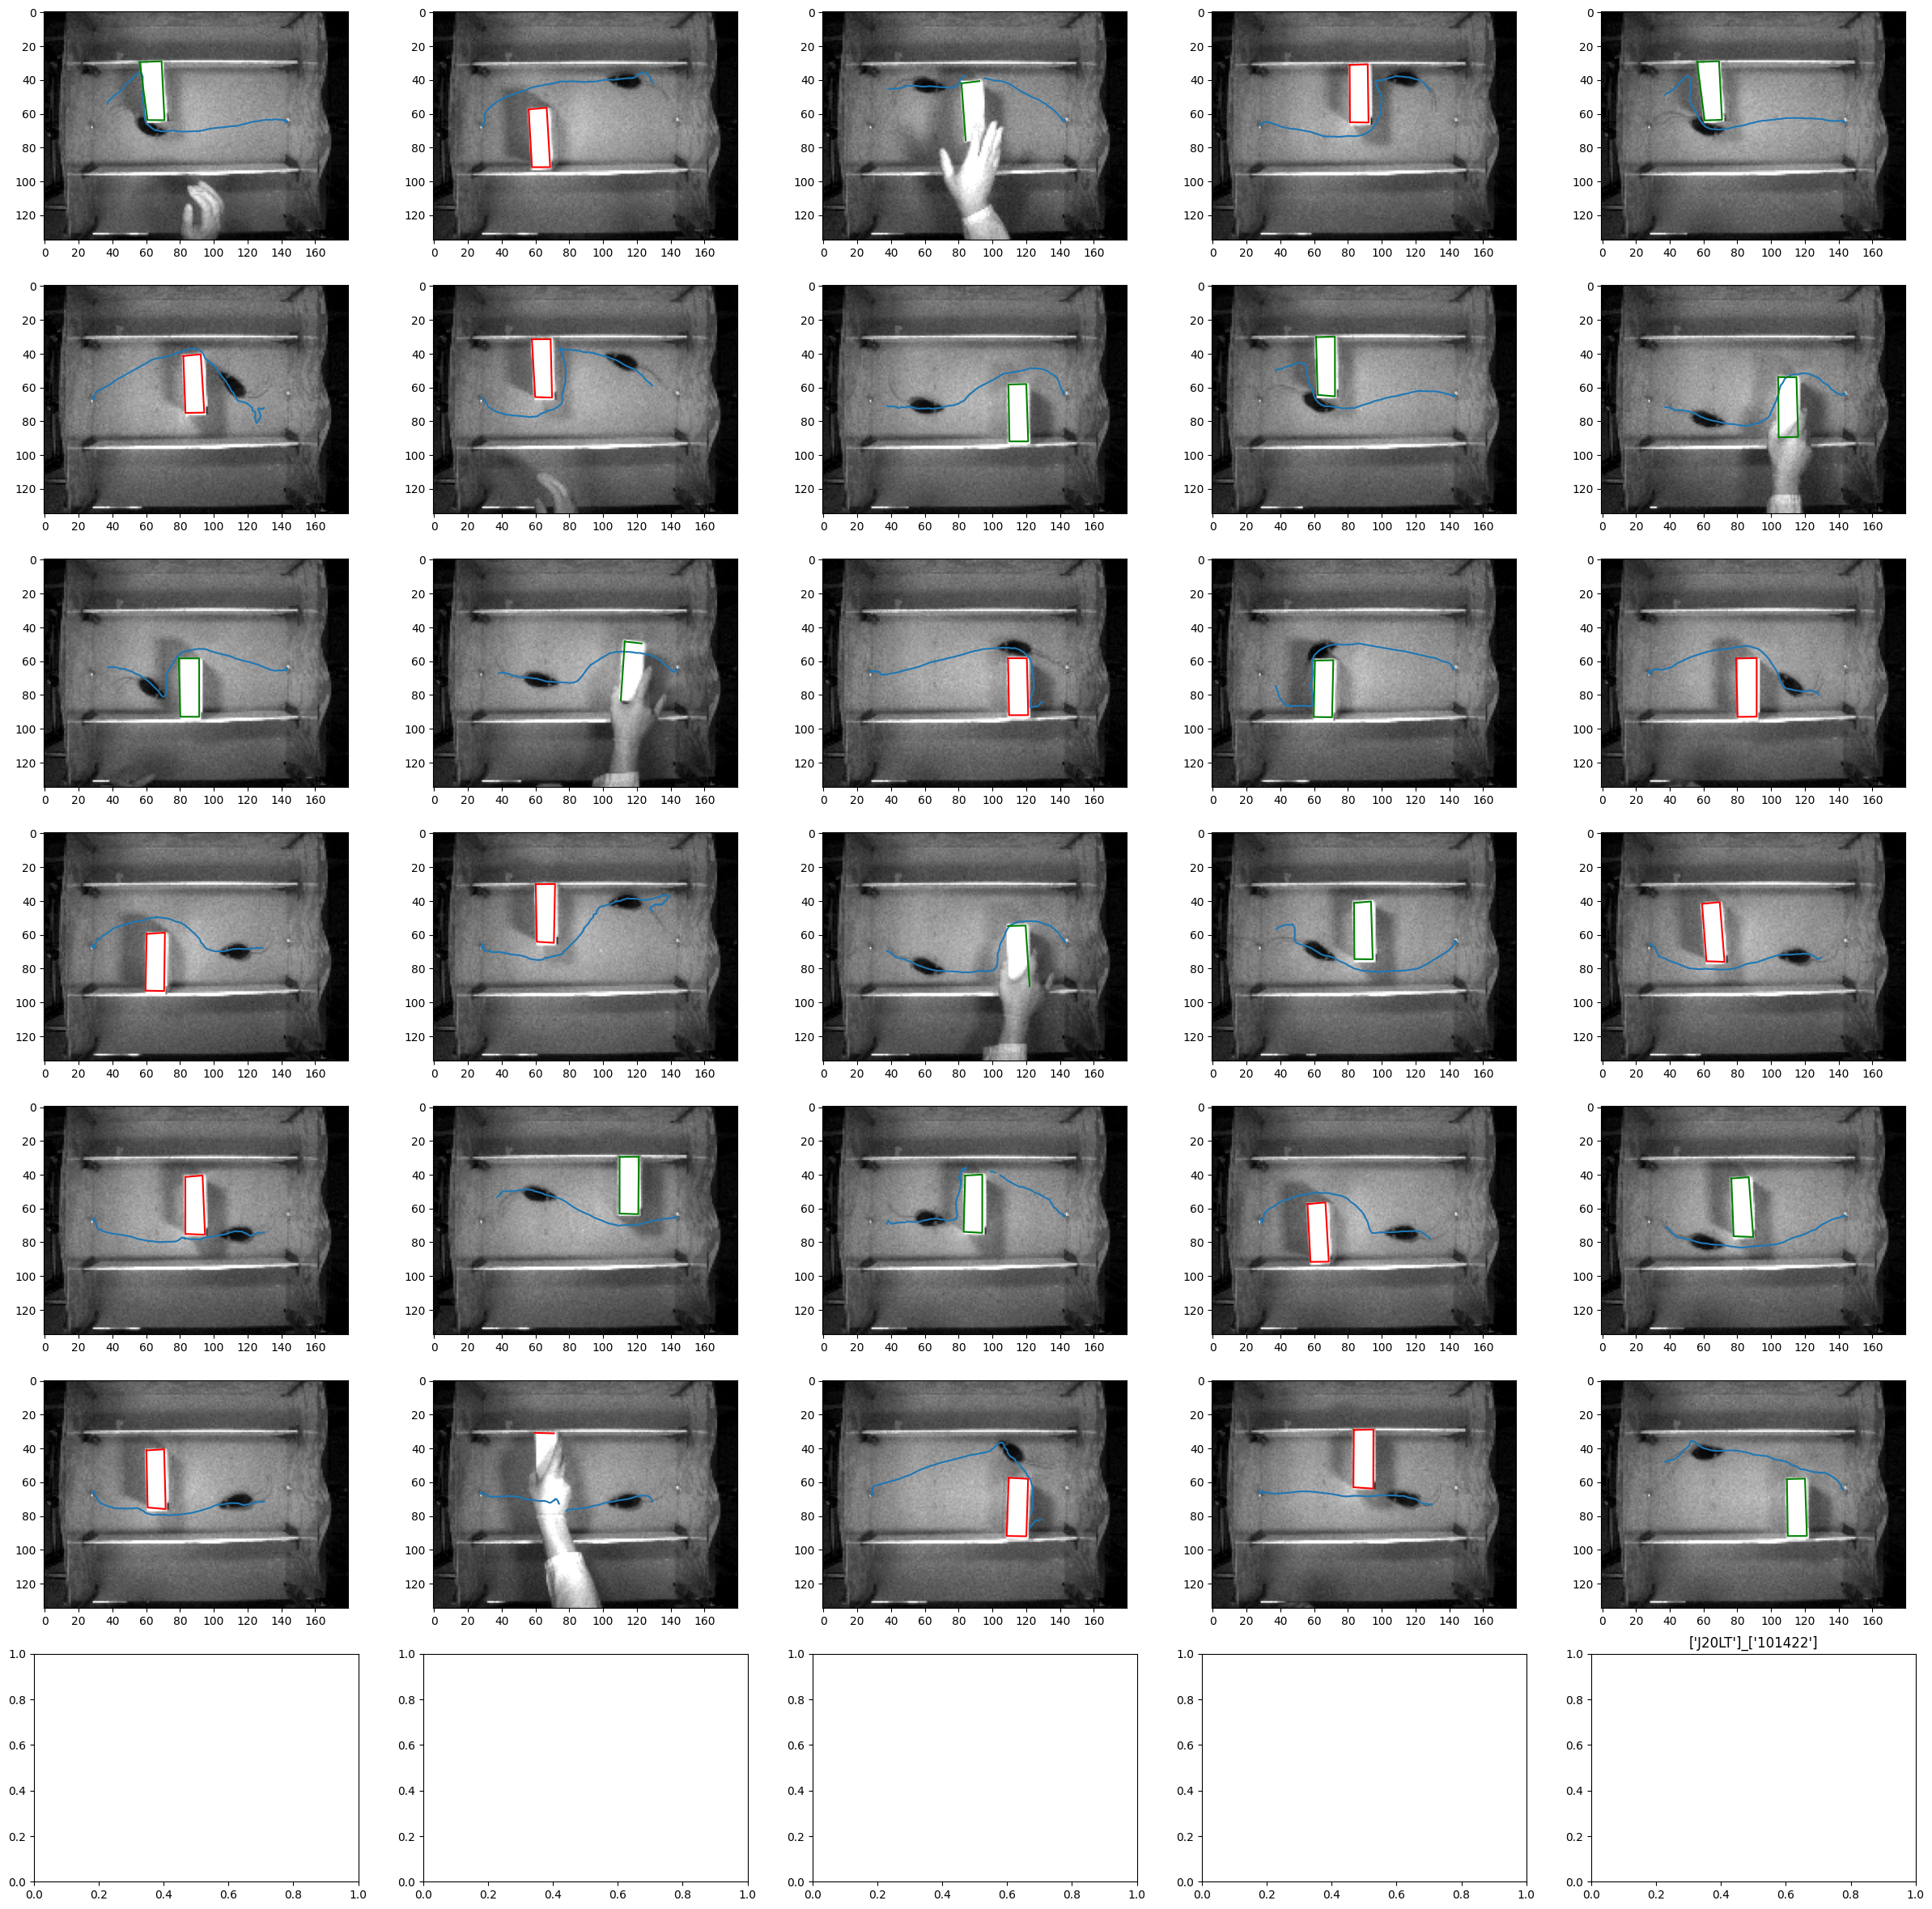

In [364]:
## Plot frame of trace
#randomly sample from df
#pdf = pdf(os.path.join())
sample = 30
sample_df = df.sample(sample)
plt.subplots(int(sample//4),5 ,figsize=(30,10*(sample/10)))
plt.gca().set_title(str(df['animal'].unique()) + '_' + str(df['date'].unique()))
count = 0
dwnsmpl = .25
for ind,row in sample_df.iterrows():
    if row['odd'] == True:
        nose_list = row['nose_x_cm'] 
        odd_ind = np.argmax(nose_list>30)
        frame_ind = list(itertools.chain(row['trial_vidframes']))[odd_ind]
        frame = frames[frame_ind]
        plt.subplot((int(sample//4)),5,count+1)
        plt.imshow(frame,cmap='gray')
        plt.plot(row['gt_nose_x']*dwnsmpl,row['gt_nose_y']*dwnsmpl)
        plt.plot([row['obstacleTL_x'][odd_ind]*dwnsmpl, row['obstacleTR_x'][odd_ind]*dwnsmpl, row['obstacleBR_x'][odd_ind]*dwnsmpl, row['obstacleBL_x'][odd_ind]*dwnsmpl,row['obstacleTL_x'][odd_ind]*dwnsmpl],
                [row['obstacleTL_y'][odd_ind]*dwnsmpl, row['obstacleTR_y'][odd_ind]*dwnsmpl, 
                row['obstacleBR_y'][odd_ind]*dwnsmpl, row['obstacleBL_y'][odd_ind]*dwnsmpl,row['obstacleTL_y'][odd_ind]*dwnsmpl],color='green')
    
         


        
        #use odd_ind to index into obstacle 
        # iterate over columns list 
        #create gt_obstacle points
    else: 
        nose_list = row['nose_x_cm']
        even_ind = np.argmax(nose_list<45)
        frame_ind = list(itertools.chain(*row['trial_vidframes']))[even_ind]
        frame = frames[frame_ind]

        plt.subplot((int(sample//4)),5,count+1)
        plt.imshow(frame,cmap='gray')
        plt.plot(row['gt_nose_x']*dwnsmpl,row['gt_nose_y']*dwnsmpl)
        plt.plot([row['obstacleTL_x'][even_ind]*dwnsmpl, row['obstacleTR_x'][even_ind]*dwnsmpl, row['obstacleBR_x'][even_ind]*dwnsmpl, row['obstacleBL_x'][even_ind]*dwnsmpl,row['obstacleTL_x'][even_ind]*dwnsmpl],
                [row['obstacleTL_y'][even_ind]*dwnsmpl, row['obstacleTR_y'][even_ind]*dwnsmpl, 
                row['obstacleBR_y'][even_ind]*dwnsmpl, row['obstacleBL_y'][even_ind]*dwnsmpl,row['obstacleTL_y'][even_ind]*dwnsmpl],color='red') 
    count += 1
            

244
239


(0.0, 72.0)

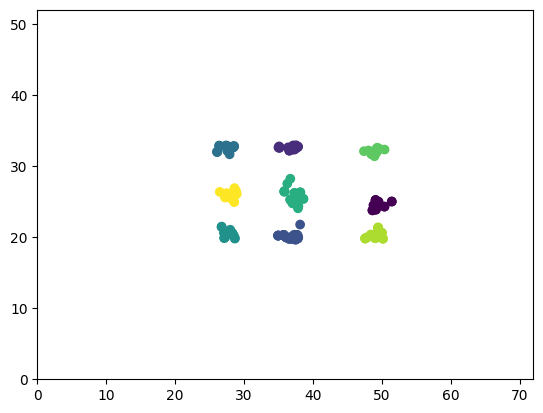

In [423]:
print(len(df))
df = df[df['gt_obstacle_cen_x_cm'].notna()]
print(len(df))

kmeans_input = np.vstack([df['gt_obstacle_cen_x_cm'].values, df['gt_obstacle_cen_y_cm'].values])

kmeans_input = np.transpose(kmeans_input)

labels = KMeans(n_clusters=9).fit(kmeans_input).labels_
df['obstacle_cluster'] = labels



plt.scatter(df['gt_obstacle_cen_x_cm'], df['gt_obstacle_cen_y_cm'], c=labels)
plt.ylim([0,52]); plt.xlim([0, 72])

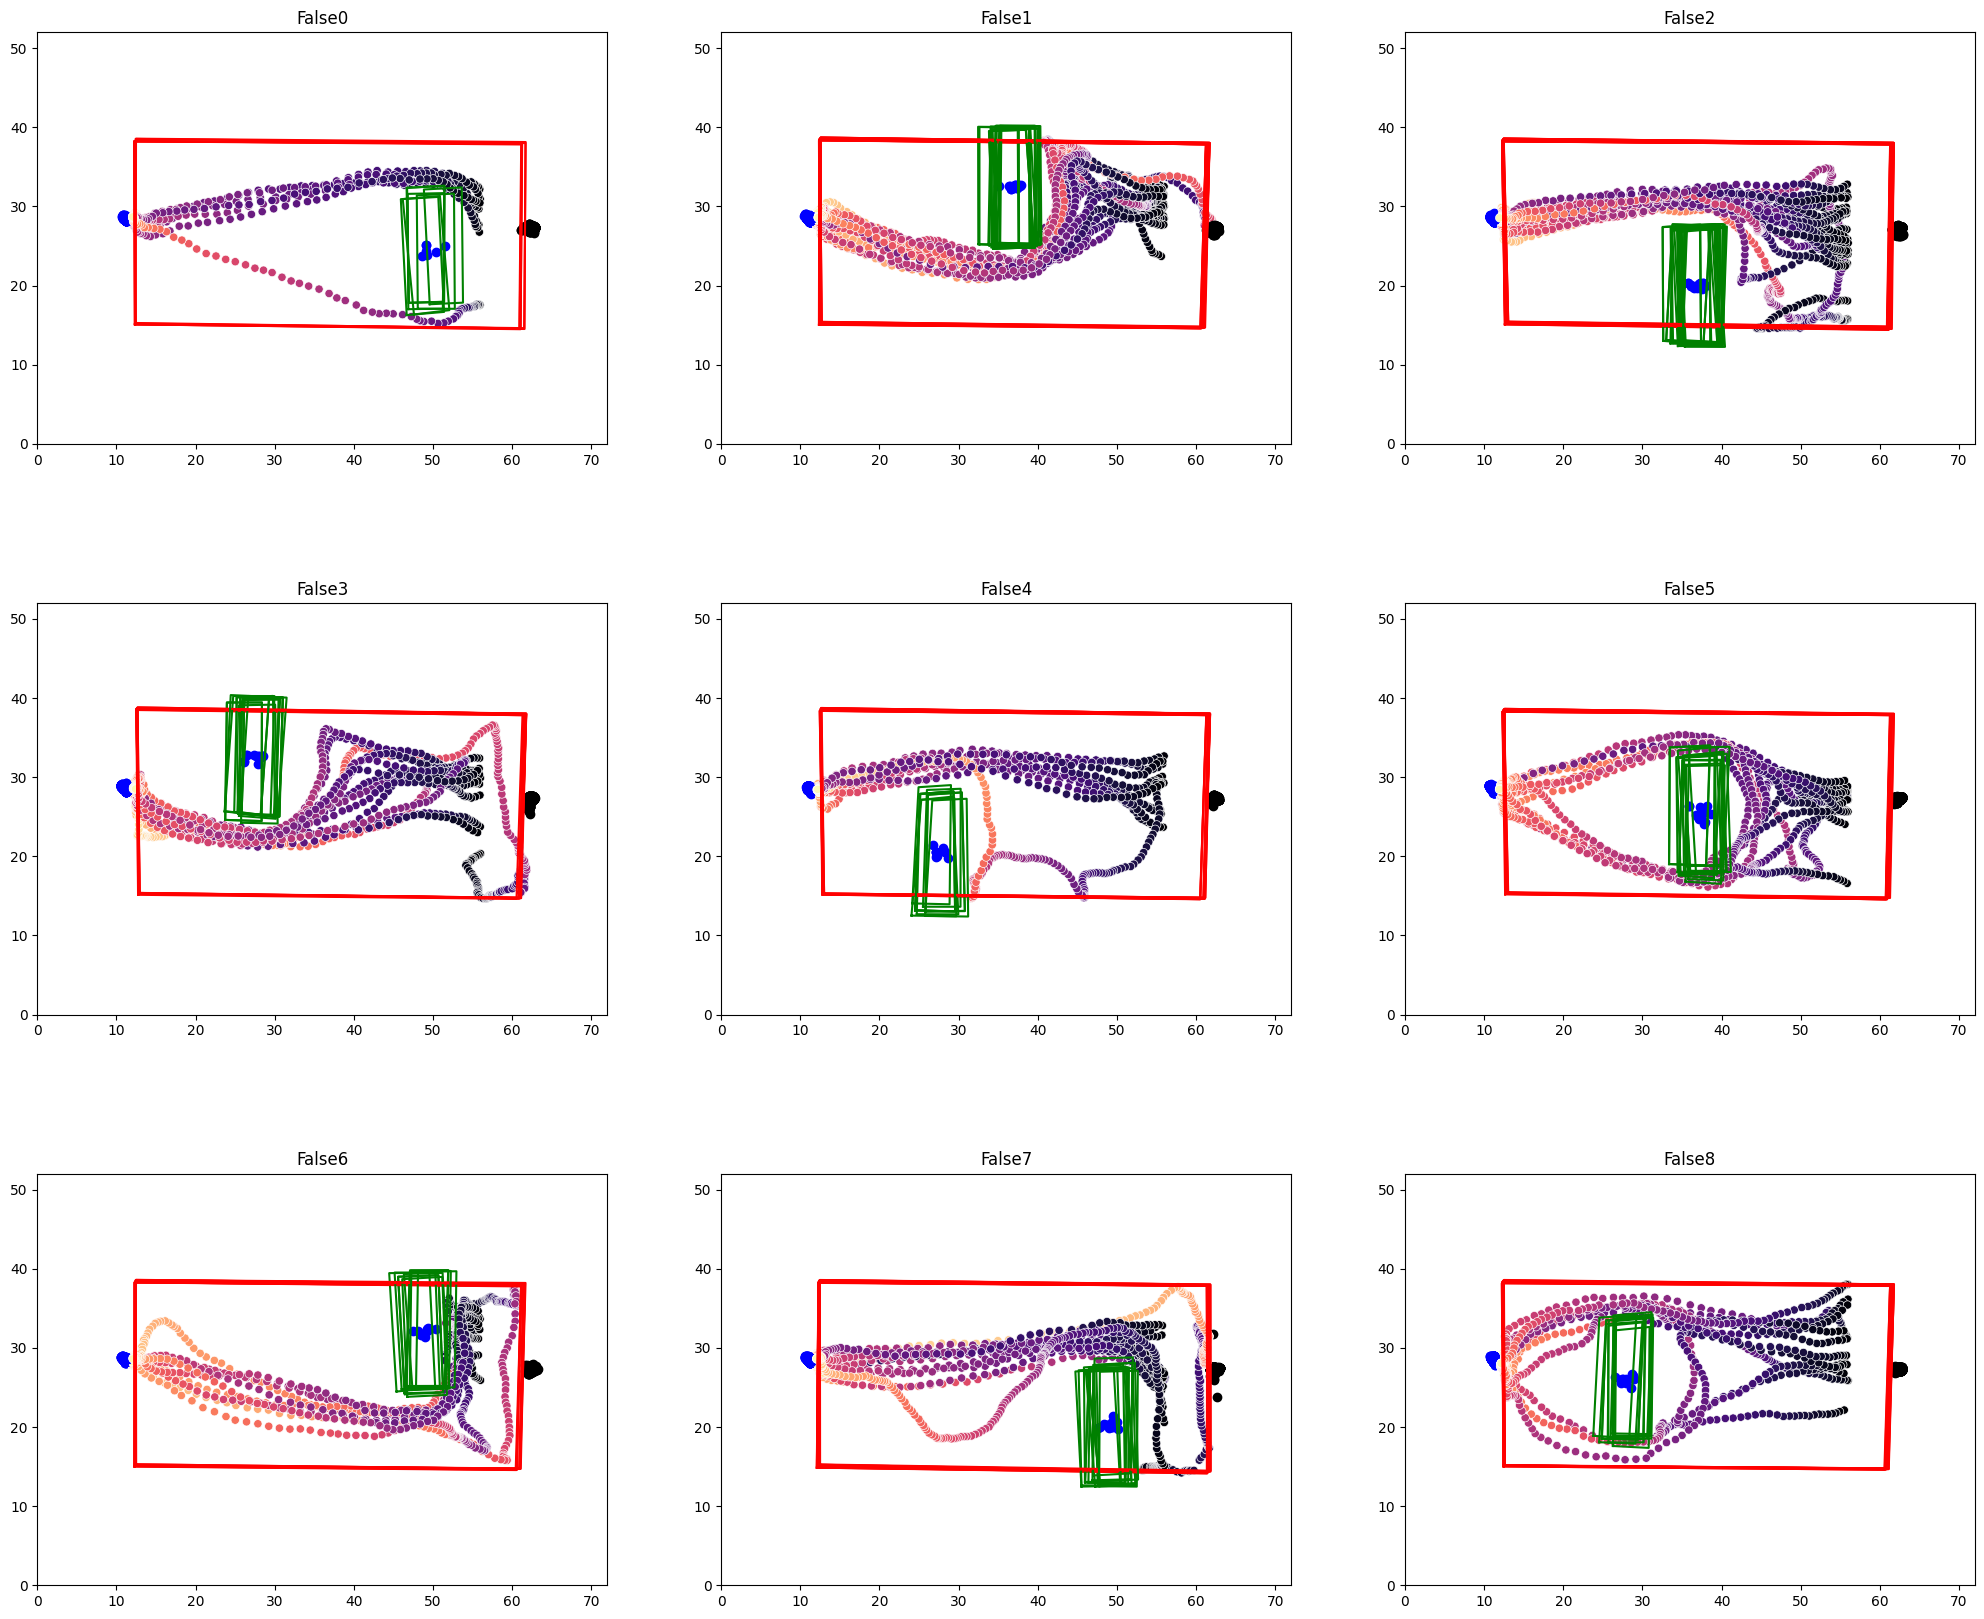

In [424]:
plt.subplots(3,3, figsize=(25,21))


for clusters, cluster_name in enumerate(df['obstacle_cluster'].unique()):
    x=df.loc[df['obstacle_cluster']==cluster_name]
    for i, row in x.iterrows():
        if row['odd'] == False:
            plt.subplot(3,3,cluster_name+1)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.gca().set_title(str(row['odd'])+str(row['obstacle_cluster']))
    
            plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='red')


            plt.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
                [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')
    
   
    
    
            plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='blue')
            plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
            plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')
            sns.scatterplot(x=row['ts_nose_x_cm'],y=row['ts_nose_y_cm'],hue = enumerate(row['ts_nose_x_cm']), palette ='magma',legend=False) 
            #plt.scatter(row['wobstacle_x_cm'], row['wobstacle_y_cm'], c = list(mcolors.TABLEAU_COLORS)[ row['obstacle_cluster']])
            plt.ylim([0,52]); plt.xlim([0, 72])

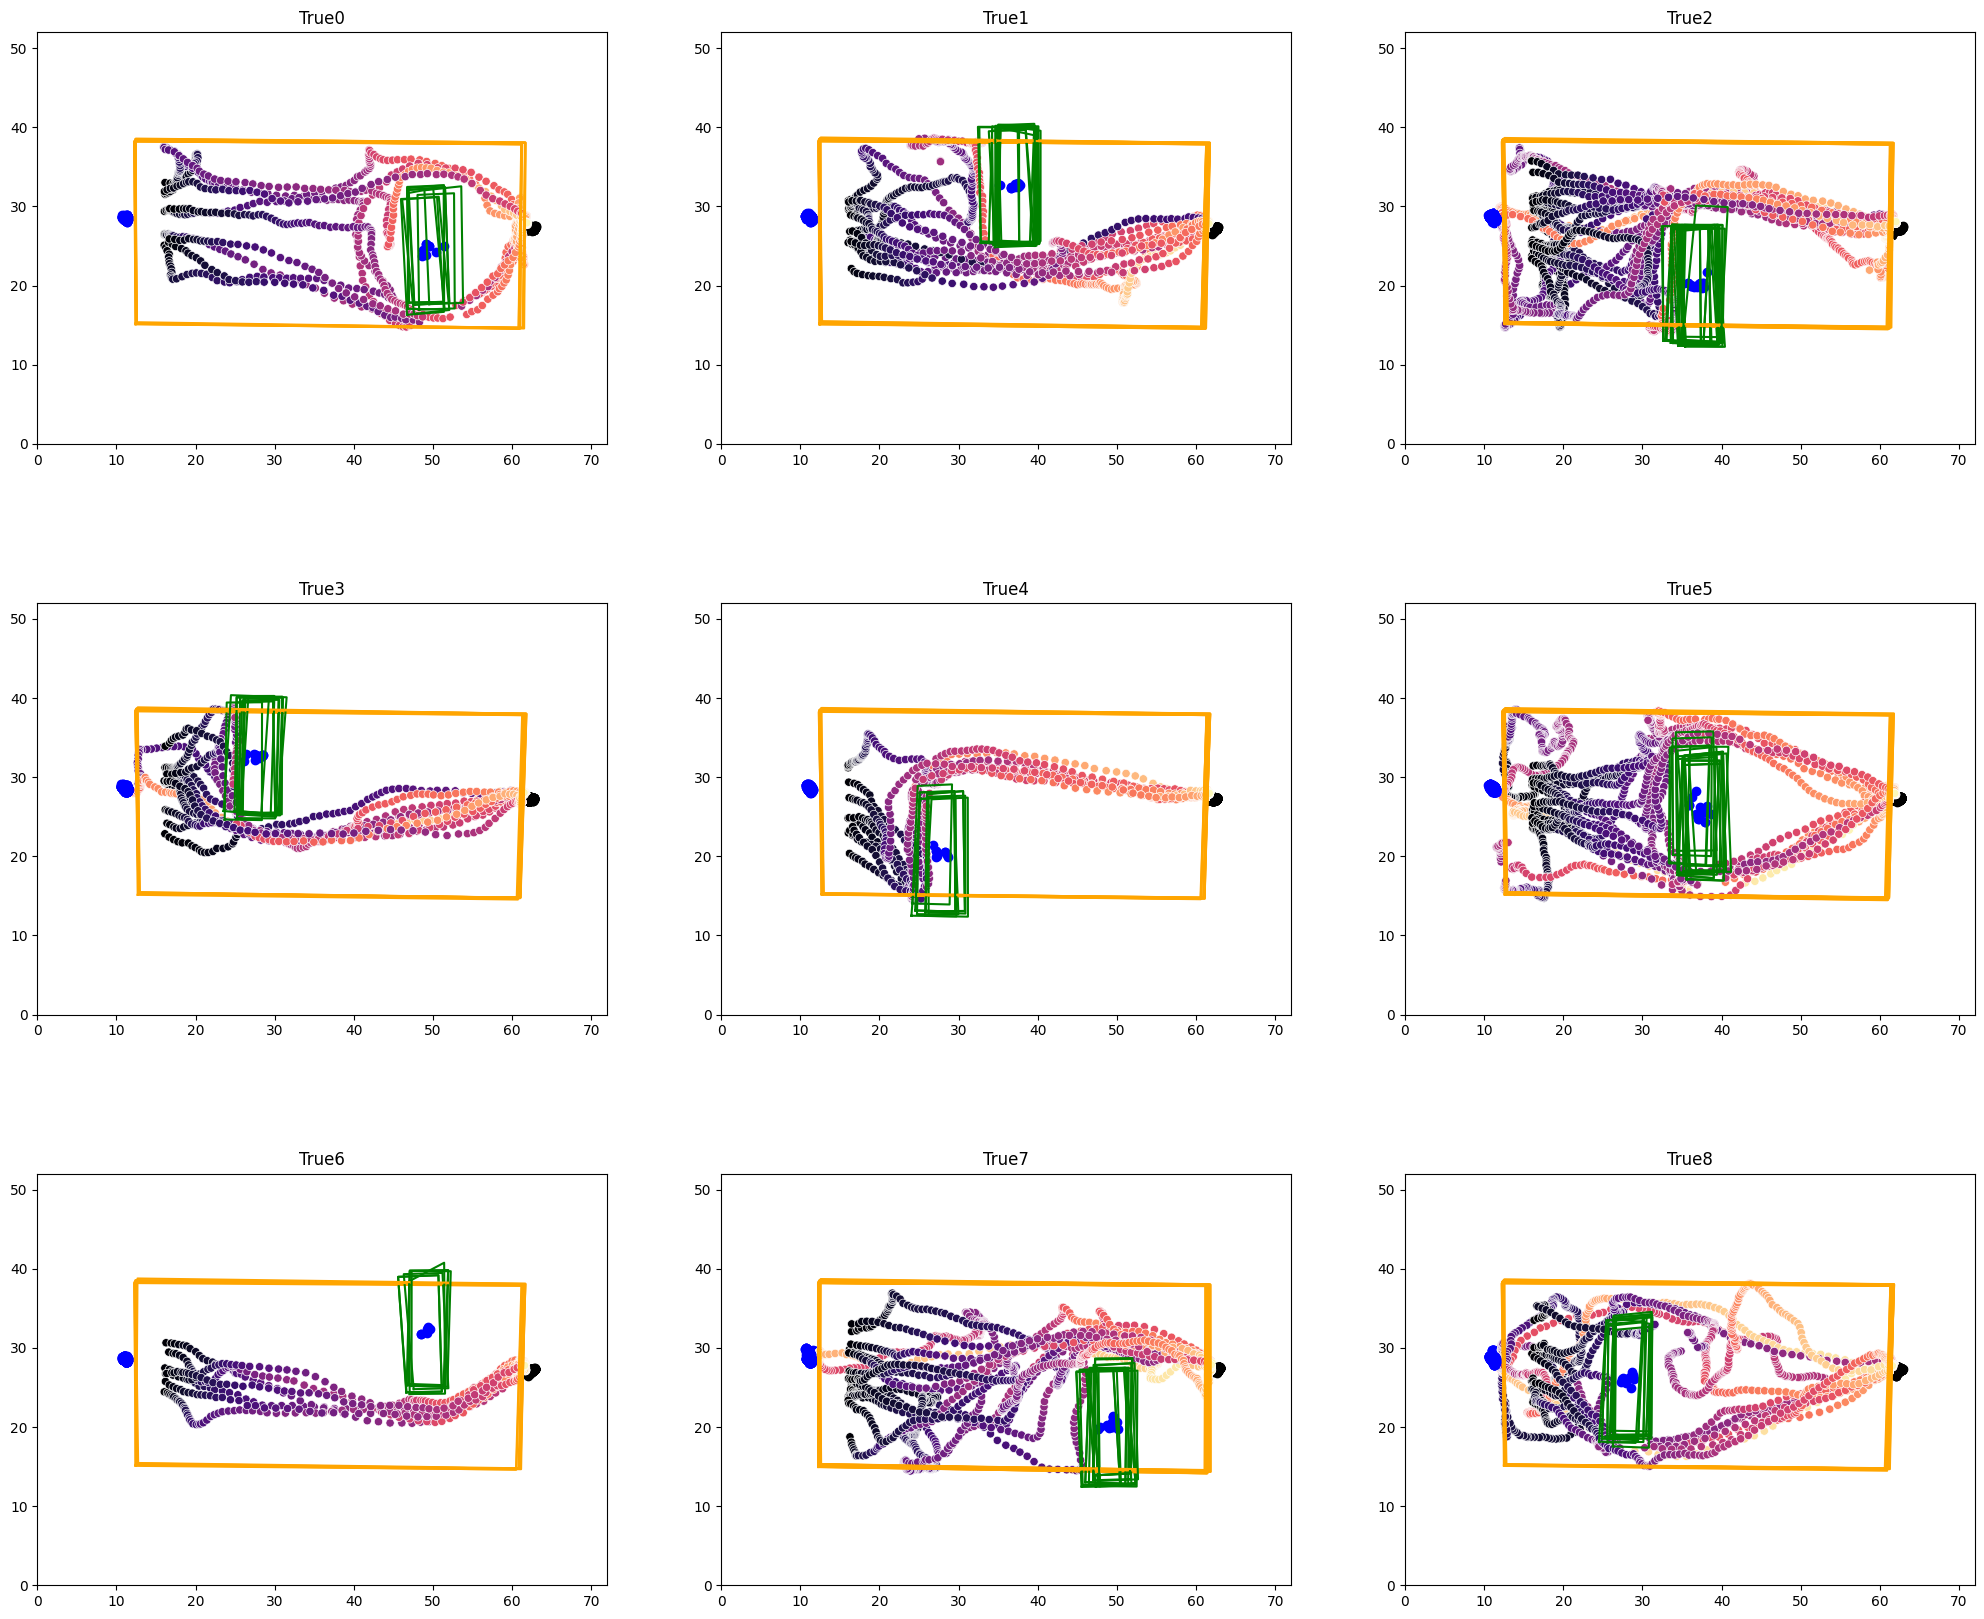

In [425]:
plt.subplots(3,3, figsize=(25,21))


for clusters, cluster_name in enumerate(df['obstacle_cluster'].unique()):
    x=df.loc[df['obstacle_cluster']==cluster_name]
    for i, row in x.iterrows():
        if row['odd'] == True:
            plt.subplot(3,3,cluster_name+1)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.gca().set_title(str(row['odd'])+str(row['obstacle_cluster']))
    
            plt.plot([row['arenaTL_x_cm'], row['arenaTR_x_cm'], row['arenaBR_x_cm'], row['arenaBL_x_cm'],row['arenaTL_x_cm']],
                [row['arenaTL_y_cm'], row['arenaTR_y_cm'], row['arenaBR_y_cm'], row['arenaBL_y_cm'],row['arenaTL_y_cm']],color='orange')


            plt.plot([row['gt_obstacleTL_x_cm'], row['gt_obstacleTR_x_cm'], row['gt_obstacleBR_x_cm'], row['gt_obstacleBL_x_cm'],row['gt_obstacleTL_x_cm']],
                [row['gt_obstacleTL_y_cm'], row['gt_obstacleTR_y_cm'], row['gt_obstacleBR_y_cm'], row['gt_obstacleBL_y_cm'],row['gt_obstacleTL_y_cm']],color='green')
    
   
    
    
            plt.scatter(row['gt_obstacle_cen_x_cm'],row['gt_obstacle_cen_y_cm'],color='blue')
            plt.scatter(row['leftportT_x_cm'],row['leftportT_y_cm'],color='blue')
            plt.scatter(row['rightportT_x_cm'],row['rightportT_y_cm'],color='black')
            sns.scatterplot(x=row['ts_nose_x_cm'],y=row['ts_nose_y_cm'],hue = enumerate(row['ts_nose_x_cm']), palette ='magma',legend=False) 
            #plt.scatter(row['wobstacle_x_cm'], row['wobstacle_y_cm'], c = list(mcolors.TABLEAU_COLORS)[ row['obstacle_cluster']])
            plt.ylim([0,52]); plt.xlim([0, 72])

In [101]:
for ind, animal in enumerate(df['animal'].unique()): 
    print(ind,animal)

0 J19LT
1 J19RT
2 J20LT
3 J20RT


In [100]:
odd['animal'].unique()

array(['J19LT', 'J19RT', 'J20LT', 'J20RT'], dtype=object)

In [102]:
animal_df['obstacle_cluster'].unique()

array([2, 8, 3, 0, 4, 1, 7, 6])

In [98]:
odd = df[df['odd']==True]
even = df[df['odd']==False] 

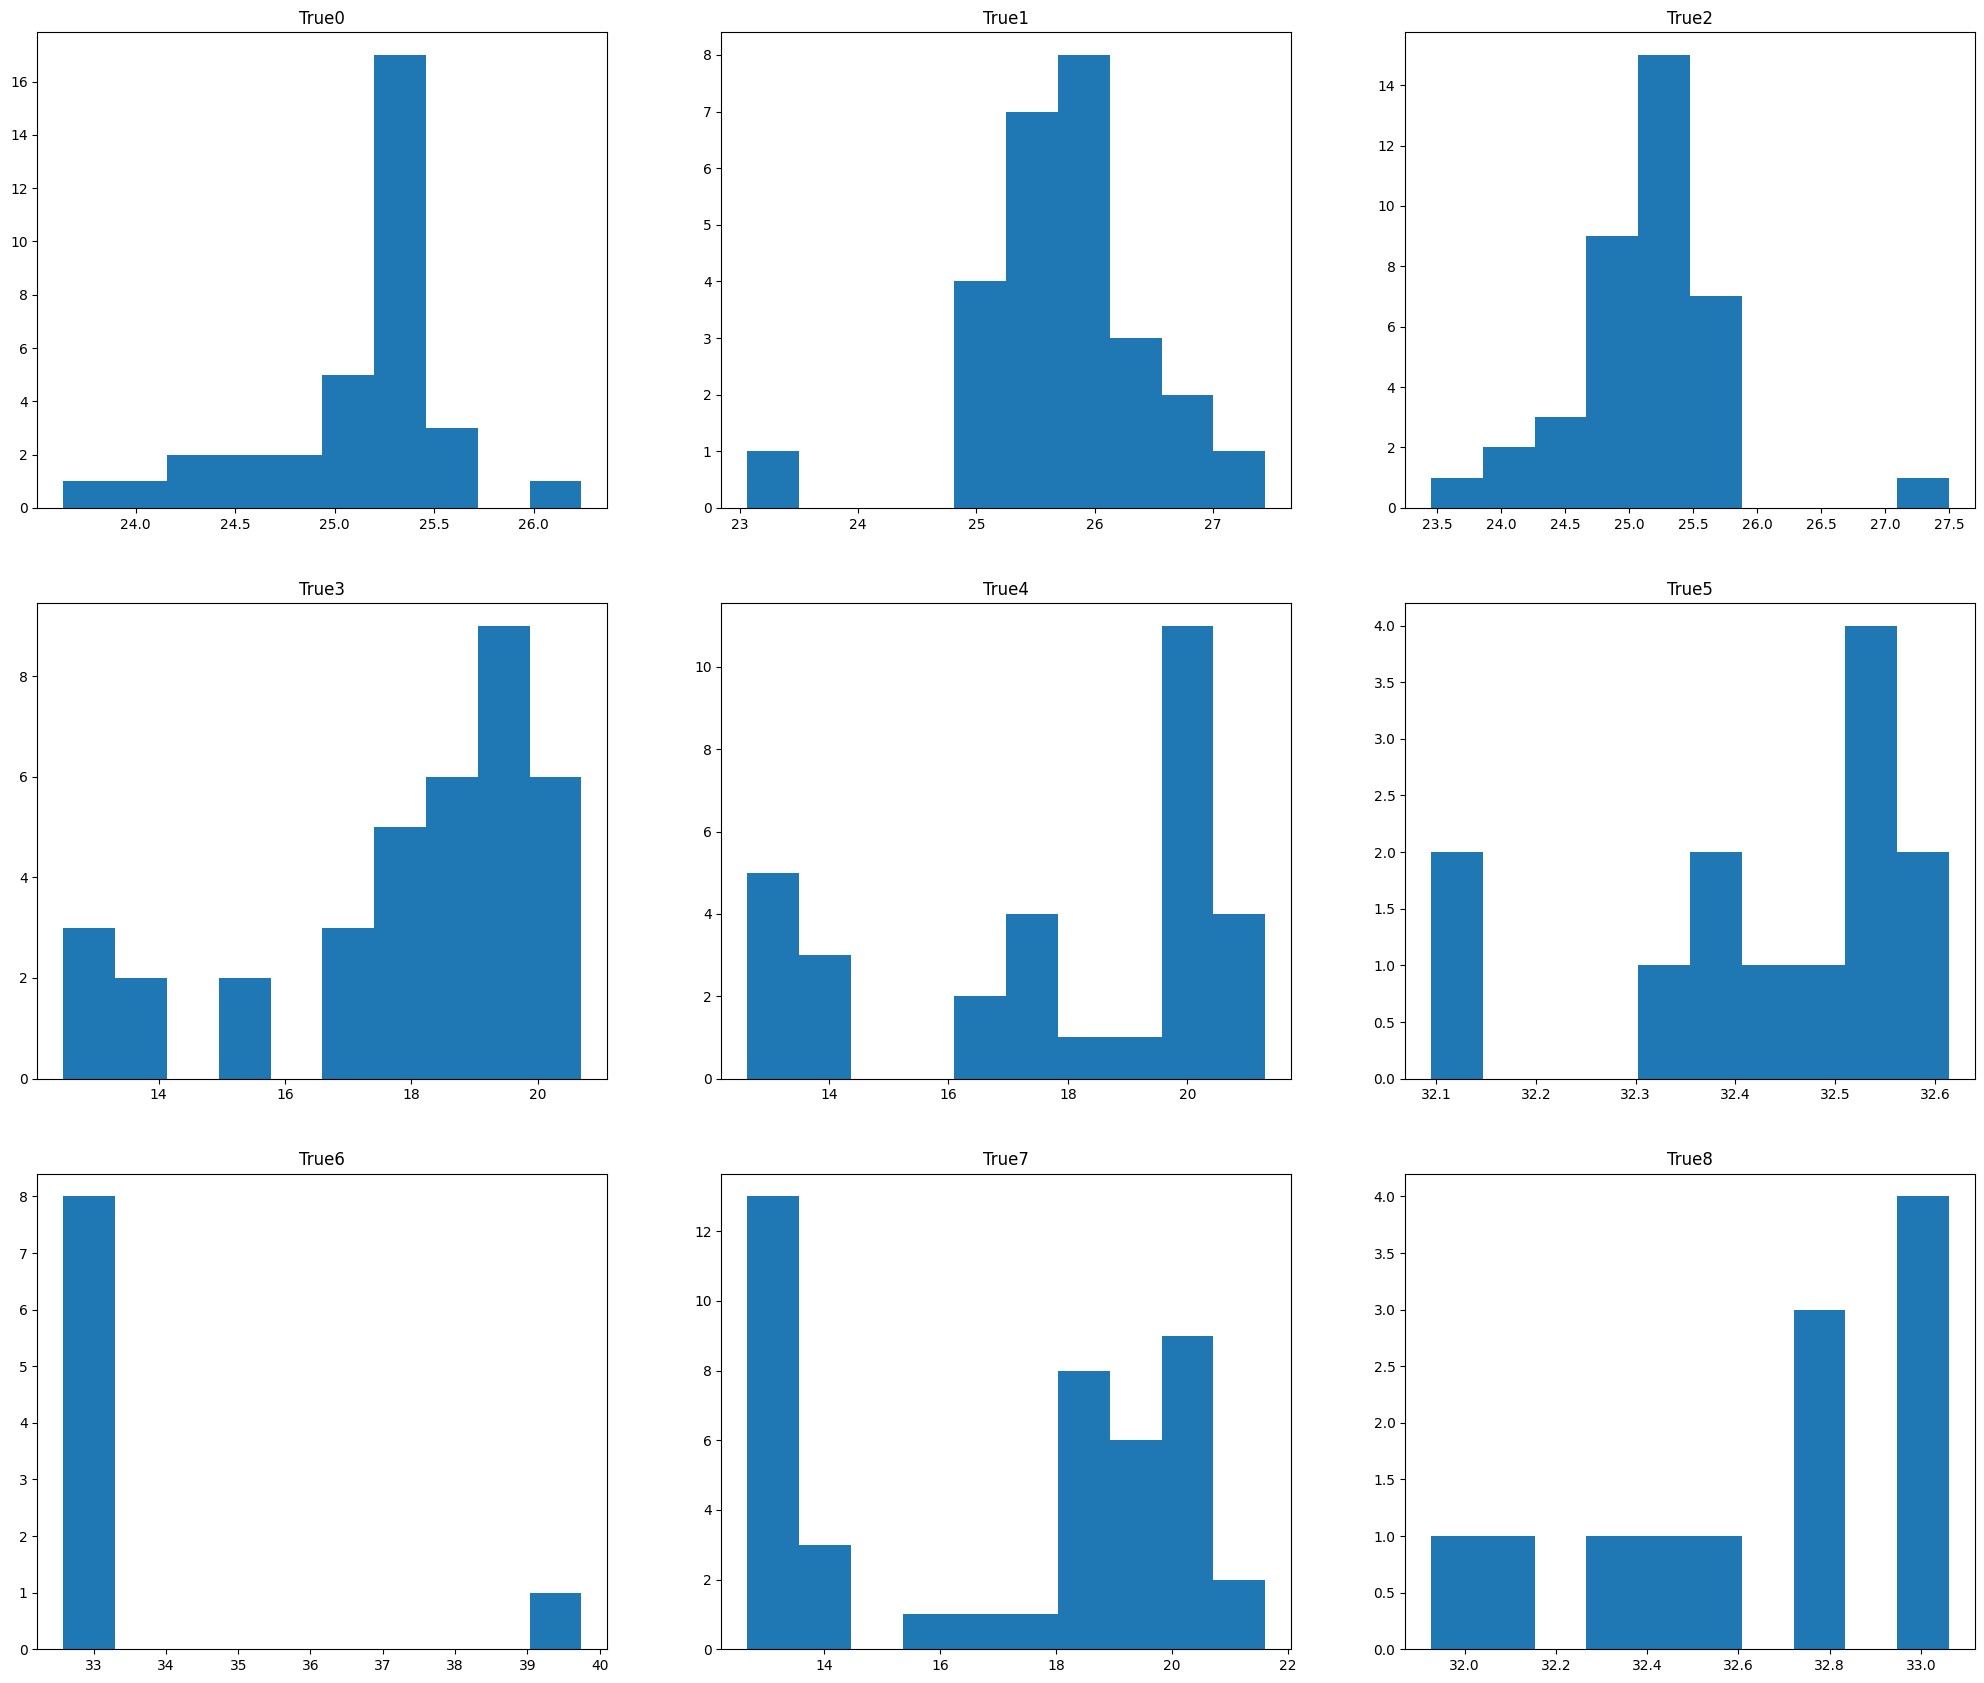

In [105]:
plt.subplots(3,3, figsize=(25,21))


for clusters, cluster_name in enumerate(odd['obstacle_cluster'].unique()):
    x=odd.loc[odd['obstacle_cluster']==cluster_name]
    x= x.reset_index()
    
    plt.subplot(3,3,cluster_name+1)
    #plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_title(str(x.at[1,'odd'])+str(x.at[1,'obstacle_cluster']))
    plt.hist(x['gt_obstacle_cen_y_cm'])

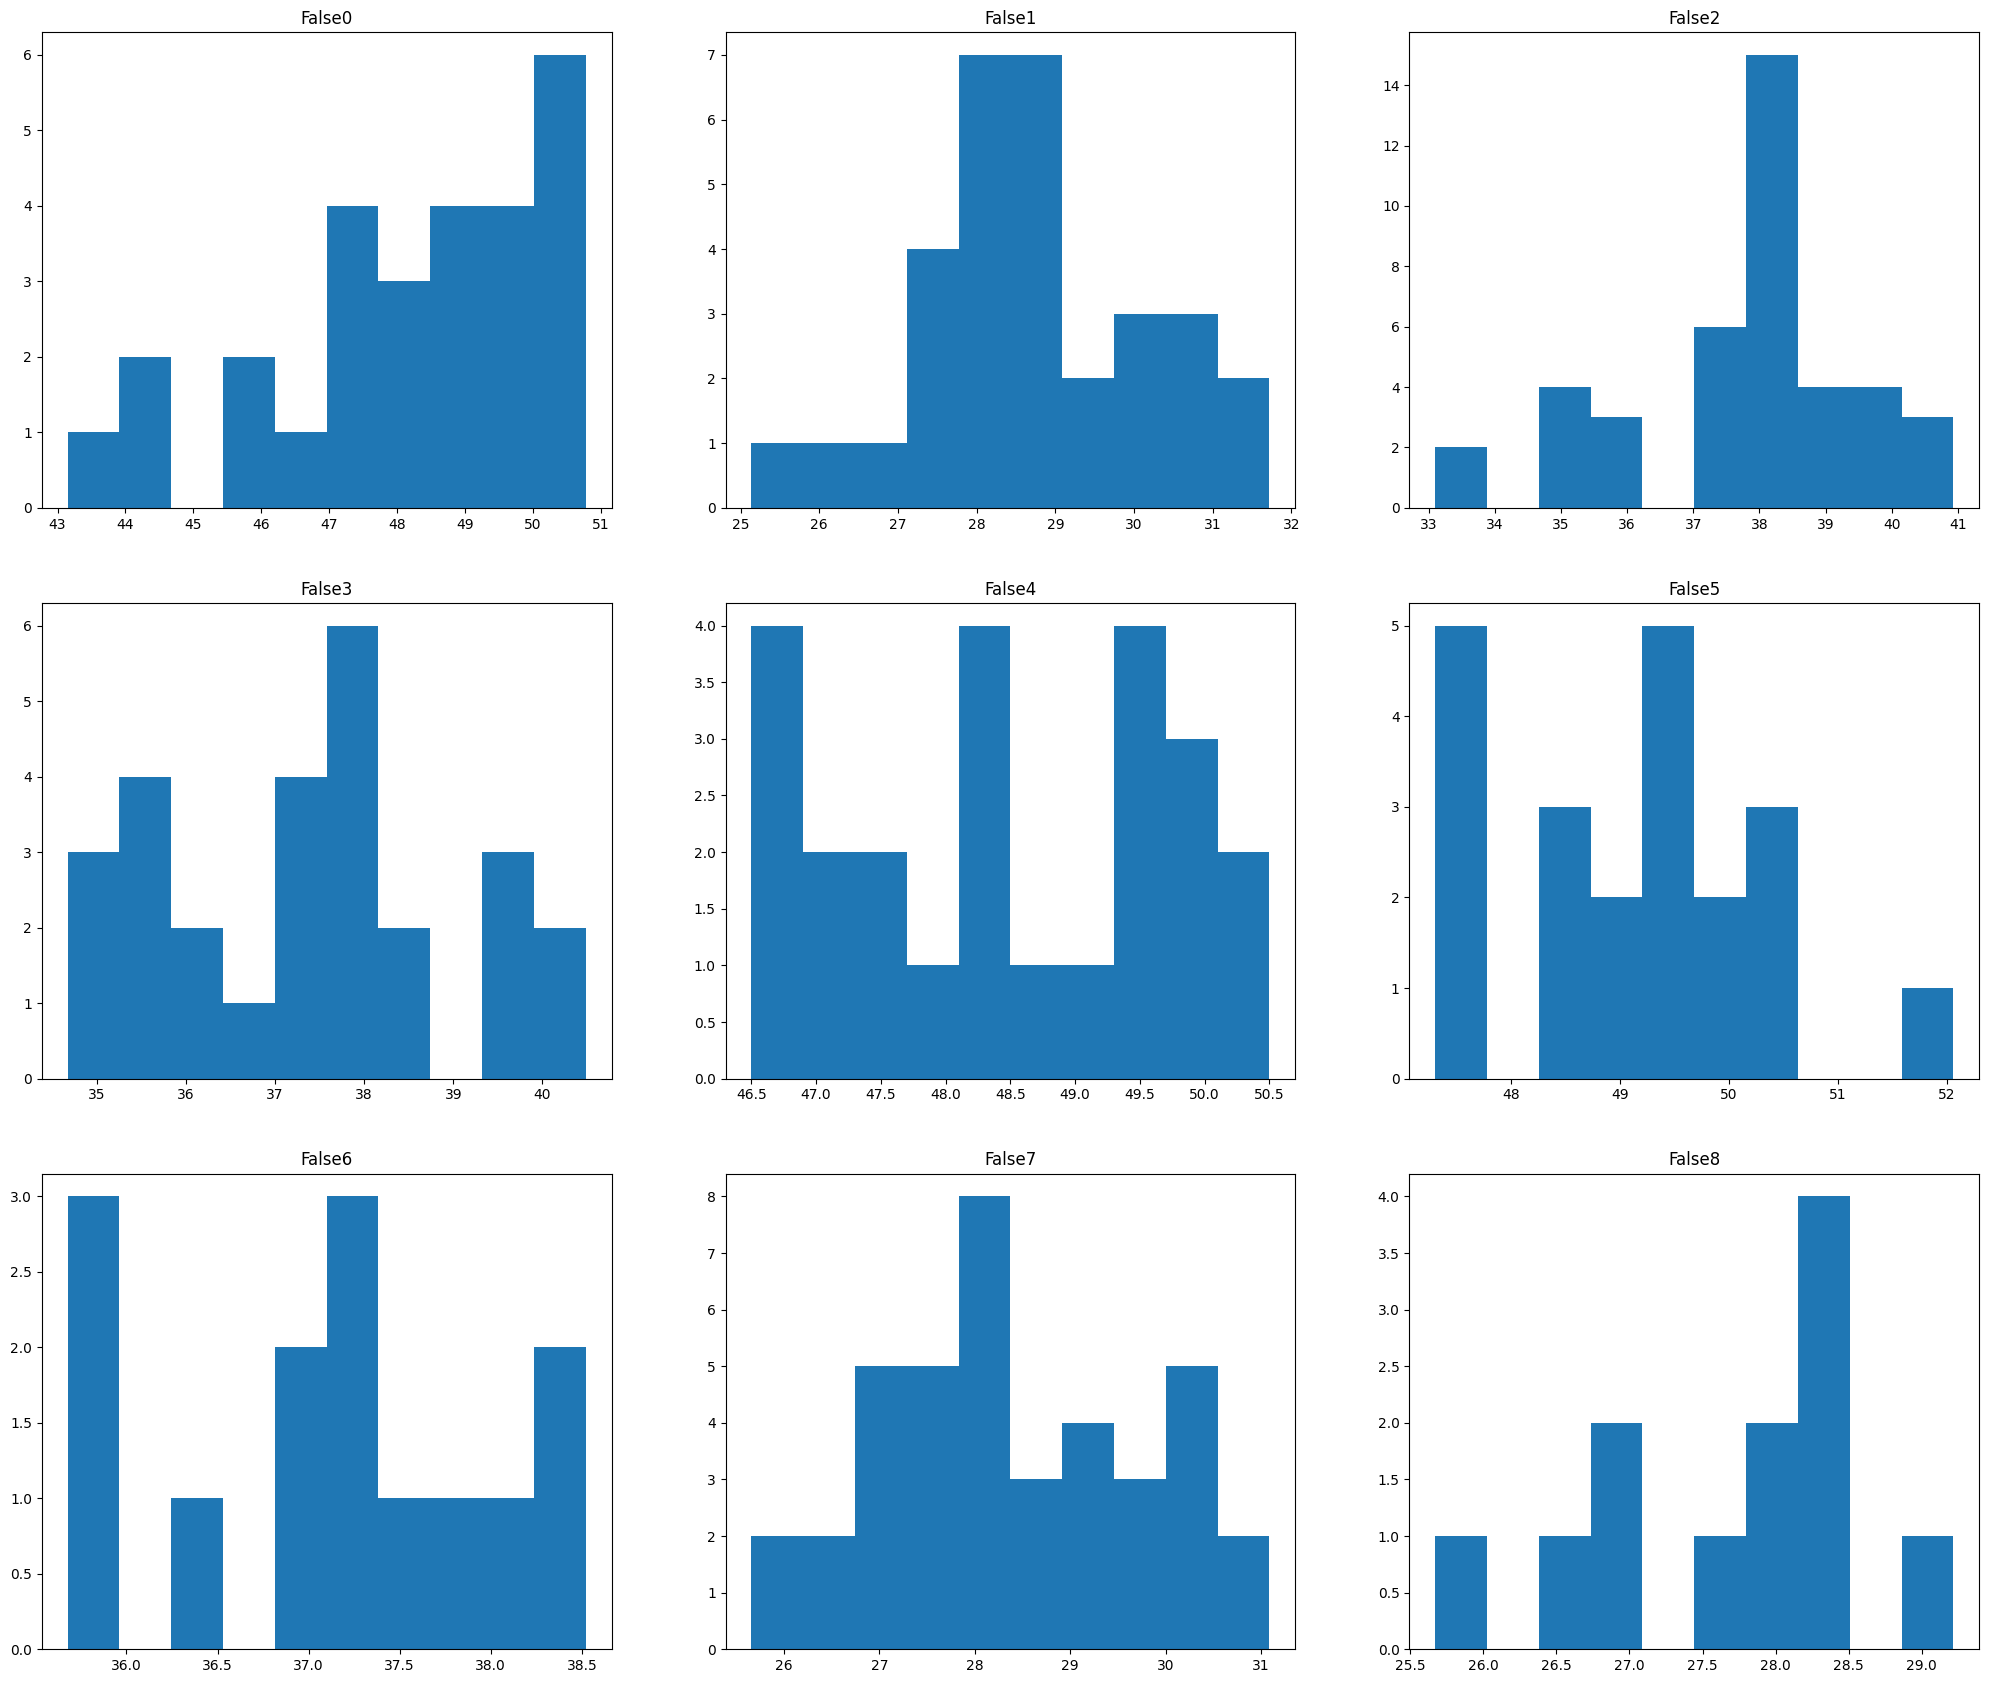

In [94]:
plt.subplots(3,3, figsize=(25,21))


for clusters, cluster_name in enumerate(even['obstacle_cluster'].unique()):
    x=even.loc[even['obstacle_cluster']==cluster_name]
    x= x.reset_index()
    
    plt.subplot(3,3,cluster_name+1)
    #plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_title(str(x.at[1,'odd'])+str(x.at[1,'obstacle_cluster']))
    plt.hist(x['gt_obstacle_cen_x_cm'])

In [90]:
x

first_poke   second_poke  \
0    53940.094643  53944.297369   
5    53963.832844  53966.241420   
6    53966.241420  53970.493478   
12   53986.018547  53989.561958   
19   54008.777868  54011.203136   
..            ...           ...   
439  55715.148288  55718.790016   
462  55825.462988  55828.510720   
463  55828.510720  55832.275302   
464  55832.275302  55834.945958   
465  55834.945958  55838.218944   

                                      trial_timestamps  \
0    [53940.098099, 53940.114764, 53940.131865, 539...   
5    [53963.83968, 53963.856256, 53963.873075, 5396...   
6    [53966.257177, 53966.273868, 53966.290508, 539...   
12   [53986.031411, 53986.047398, 53986.064, 53986....   
19   [54008.788505, 54008.805248, 54008.822272, 540...   
..                                                 ...   
439  [55715.152204, 55715.1696, 55715.1856, 55715.2...   
462  [55825.474316, 55825.490444, 55825.50711, 5582...   
463  [55828.525004, 55828.542067, 55828.558259, 558...   
464  [55832.27694, 55832.29294, 55832.309542, 55832...   
465  [55834.960512, 55834.977113, 55834.994265, 558...   

                                       trial_vidframes  \
0    [[1065, 1066, 1067, 1068, 1069, 1070, 1071, 10...   
5    [2489, 2490, 2491, 2492, 2493, 2494, 2495, 249...   
6    [[2634, 2635, 2636, 2637, 2638, 2639, 2640, 26...   
12   [[3820, 3821, 3822, 3823, 3824, 3825, 3826, 38...   
19   [5185, 5186, 5187, 5188, 5189, 5190, 5191, 519...   
..                                                 ...   
439  [[7683, 7684, 7685, 7686, 7687, 7688, 7689, 76...   
462  [14300, 14301, 14302, 14303, 14304, 14305, 143...   
463  [[14483, 14484, 14485, 14486, 14487, 14488, 14...   
464  [14708, 14709, 14710, 14711, 14712, 14713, 147...   
465  [[14869, 14870, 14871, 14872, 14873, 14874, 14...   

                                                nose_x  \
0    [573.6846923828125, 573.556884765625, 573.9543...   
5    [112.24656677246094, 111.9286880493164, 111.85...   
6    [570.74755859375, 570.910888671875, 570.851318...   
12   [570.6533813476562, 570.4749755859375, 570.645...   
19   [112.84830474853516, 112.87919616699219, 112.6...   
..                                                 ...   
439  [572.6892700195312, 573.0925903320312, 573.160...   
462  [112.08391571044922, 112.02930450439453, 112.3...   
463  [573.5639038085938, 573.6708374023438, 573.240...   
464  [111.84568786621094, 111.89108276367188, 112.4...   
465  [574.6337280273438, 574.7807006835938, 575.202...   

                                                nose_y  \
0    [254.9643096923828, 255.49862670898438, 254.77...   
5    [263.5496826171875, 263.3453674316406, 262.960...   
6    [258.3409729003906, 258.5339660644531, 258.525...   
12   [257.4539489746094, 257.3938293457031, 258.237...   
19   [262.04974365234375, 261.6461486816406, 262.11...   
..                                                 ...   
439  [257.46923828125, 257.9422912597656, 257.84613...   
462  [264.7166442871094, 265.0281677246094, 264.991...   
463  [258.8786315917969, 258.5501403808594, 258.936...   
464  [262.9996643066406, 262.94903564453125, 262.85...   
465  [260.6539306640625, 260.25921630859375, 260.20...   

                                       nose_likelihood  \
0    [0.9999905824661255, 0.9999914169311523, 0.999...   
5    [0.9999994039535522, 0.9999994039535522, 0.999...   
6    [0.9999992847442627, 0.9999995231628418, 0.999...   
12   [0.9999990463256836, 0.9999988079071045, 0.999...   
19   [0.9999998807907104, 0.9999998807907104, 0.999...   
..                                                 ...   
439  [0.9999996423721313, 0.9999997615814209, 0.999...   
462  [0.9999998807907104, 0.9999998807907104, 0.999...   
463  [0.9999997615814209, 0.9999997615814209, 0.999...   
464  [0.9999998807907104, 0.9999998807907104, 0.999...   
465  [0.9999997615814209, 0.9999996423721313, 0.999...   

                                             leftear_x  \
0    [552.3197631835938, 552.917236328125, 